In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time

In [3]:
# cap=cv2.VideoCapture(0)
# while cap.isOpened():
#   ret,frame=cap.read()
#   cv2.imshow('open cv feed',frame)
#   if cv2.waitKey(10) & 0xFF==ord('q'):
#     break
# cap.release()
# cv2.destroyAllWindows()

In [4]:
!pip list

Package                       Version
----------------------------- -------------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.1
anaconda-navigator            2.4.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
bi

In [51]:
import mediapipe as mp

In [5]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [6]:

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [7]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [8]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [9]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

## extract key points

In [10]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# set up folder


In [11]:
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [13]:
for action in actions: 
   
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

## collecting data

In [14]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

## preprosing the data

In [24]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [25]:
label_map = {label:num for num, label in enumerate(actions)}

In [26]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [27]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [28]:
np.array(sequences).shape

(90, 30, 1662)

In [29]:
np.array(labels).shape

(90,)

In [30]:
X = np.array(sequences)

In [31]:
X.shape

(90, 30, 1662)

In [32]:
y = to_categorical(labels).astype(int)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [34]:
y_test.shape

(5, 3)

## build model

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [36]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [37]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [38]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [39]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 10s 182ms/step - loss: 1.1097 - categorical_accuracy: 0.3529
Epoch 2/2000
3/3 [==============================] - 0s 169ms/step - loss: 2.2337 - categorical_accuracy: 0.3176
Epoch 3/2000
3/3 [==============================] - 0s 160ms/step - loss: 2.2463 - categorical_accuracy: 0.2824
Epoch 4/2000
3/3 [==============================] - 0s 173ms/step - loss: 2.0313 - categorical_accuracy: 0.4000
Epoch 5/2000
3/3 [==============================] - 0s 169ms/step - loss: 2.2743 - categorical_accuracy: 0.3647
Epoch 6/2000
3/3 [==============================] - 1s 175ms/step - loss: 2.2701 - categorical_accuracy: 0.2941
Epoch 7/2000
3/3 [==============================] - 0s 172ms/step - loss: 3.2291 - categorical_accuracy: 0.2706
Epoch 8/2000
3/3 [==============================] - 1s 173ms/step - loss: 3.3409 - categorical_accuracy: 0.2235
Epoch 9/2000
3/3 [==============================] - 0s 166ms/step - loss: 2.0410 - categorical_accuracy

3/3 [==============================] - 0s 163ms/step - loss: 3.4100 - categorical_accuracy: 0.3294
Epoch 73/2000
3/3 [==============================] - 1s 170ms/step - loss: 2.4340 - categorical_accuracy: 0.3412
Epoch 74/2000
3/3 [==============================] - 0s 165ms/step - loss: 3.0814 - categorical_accuracy: 0.2824
Epoch 75/2000
3/3 [==============================] - 0s 173ms/step - loss: 2.1763 - categorical_accuracy: 0.3647
Epoch 76/2000
3/3 [==============================] - 1s 174ms/step - loss: 1.8930 - categorical_accuracy: 0.3529
Epoch 77/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.2745 - categorical_accuracy: 0.3647
Epoch 78/2000
3/3 [==============================] - 0s 169ms/step - loss: 1.3066 - categorical_accuracy: 0.3765
Epoch 79/2000
3/3 [==============================] - 0s 171ms/step - loss: 1.2921 - categorical_accuracy: 0.3529
Epoch 80/2000
3/3 [==============================] - 0s 159ms/step - loss: 1.2140 - categorical_accuracy: 0.37

3/3 [==============================] - 0s 168ms/step - loss: 1.0426 - categorical_accuracy: 0.4706
Epoch 145/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0555 - categorical_accuracy: 0.4588
Epoch 146/2000
3/3 [==============================] - 0s 168ms/step - loss: 1.0415 - categorical_accuracy: 0.4706
Epoch 147/2000
3/3 [==============================] - 0s 172ms/step - loss: 1.0422 - categorical_accuracy: 0.4706
Epoch 148/2000
3/3 [==============================] - 0s 163ms/step - loss: 1.0433 - categorical_accuracy: 0.4706
Epoch 149/2000
3/3 [==============================] - 0s 166ms/step - loss: 1.0567 - categorical_accuracy: 0.4118
Epoch 150/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0584 - categorical_accuracy: 0.5059
Epoch 151/2000
3/3 [==============================] - 1s 204ms/step - loss: 1.1003 - categorical_accuracy: 0.4235
Epoch 152/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0455 - categorical_accura

Epoch 216/2000
3/3 [==============================] - 0s 169ms/step - loss: 1.0318 - categorical_accuracy: 0.4353
Epoch 217/2000
3/3 [==============================] - 0s 164ms/step - loss: 1.0401 - categorical_accuracy: 0.5059
Epoch 218/2000
3/3 [==============================] - 0s 166ms/step - loss: 1.0203 - categorical_accuracy: 0.4588
Epoch 219/2000
3/3 [==============================] - 0s 161ms/step - loss: 1.0226 - categorical_accuracy: 0.5176
Epoch 220/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0231 - categorical_accuracy: 0.4941
Epoch 221/2000
3/3 [==============================] - 0s 168ms/step - loss: 1.0254 - categorical_accuracy: 0.4471
Epoch 222/2000
3/3 [==============================] - 0s 151ms/step - loss: 1.0357 - categorical_accuracy: 0.4235
Epoch 223/2000
3/3 [==============================] - 0s 176ms/step - loss: 1.0195 - categorical_accuracy: 0.4824
Epoch 224/2000
3/3 [==============================] - 0s 173ms/step - loss: 1.0267 - cat

3/3 [==============================] - 0s 166ms/step - loss: 1.0073 - categorical_accuracy: 0.5412
Epoch 288/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0178 - categorical_accuracy: 0.5059
Epoch 289/2000
3/3 [==============================] - 0s 169ms/step - loss: 1.0019 - categorical_accuracy: 0.5294
Epoch 290/2000
3/3 [==============================] - 0s 161ms/step - loss: 1.0142 - categorical_accuracy: 0.4941
Epoch 291/2000
3/3 [==============================] - 0s 166ms/step - loss: 1.0120 - categorical_accuracy: 0.5412
Epoch 292/2000
3/3 [==============================] - 0s 169ms/step - loss: 1.0112 - categorical_accuracy: 0.4471
Epoch 293/2000
3/3 [==============================] - 0s 163ms/step - loss: 1.0064 - categorical_accuracy: 0.4941
Epoch 294/2000
3/3 [==============================] - 0s 162ms/step - loss: 1.0104 - categorical_accuracy: 0.4941
Epoch 295/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0038 - categorical_accura

Epoch 359/2000
3/3 [==============================] - 0s 167ms/step - loss: 1.1973 - categorical_accuracy: 0.3059
Epoch 360/2000
3/3 [==============================] - 0s 156ms/step - loss: 1.2541 - categorical_accuracy: 0.2941
Epoch 361/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.1926 - categorical_accuracy: 0.2588
Epoch 362/2000
3/3 [==============================] - 0s 166ms/step - loss: 1.1388 - categorical_accuracy: 0.2588
Epoch 363/2000
3/3 [==============================] - 1s 200ms/step - loss: 1.1162 - categorical_accuracy: 0.3294
Epoch 364/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.2037 - categorical_accuracy: 0.3882
Epoch 365/2000
3/3 [==============================] - 0s 169ms/step - loss: 1.1445 - categorical_accuracy: 0.3412
Epoch 366/2000
3/3 [==============================] - 1s 169ms/step - loss: 1.2173 - categorical_accuracy: 0.3059
Epoch 367/2000
3/3 [==============================] - 0s 163ms/step - loss: 1.0866 - cat

3/3 [==============================] - 0s 161ms/step - loss: 1.2715 - categorical_accuracy: 0.3529
Epoch 431/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.1388 - categorical_accuracy: 0.4235
Epoch 432/2000
3/3 [==============================] - 0s 163ms/step - loss: 1.1046 - categorical_accuracy: 0.3529
Epoch 433/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.1119 - categorical_accuracy: 0.3529
Epoch 434/2000
3/3 [==============================] - 0s 164ms/step - loss: 1.0968 - categorical_accuracy: 0.3529
Epoch 435/2000
3/3 [==============================] - 0s 161ms/step - loss: 1.1001 - categorical_accuracy: 0.3529
Epoch 436/2000
3/3 [==============================] - 0s 172ms/step - loss: 1.1004 - categorical_accuracy: 0.3529
Epoch 437/2000
3/3 [==============================] - 0s 166ms/step - loss: 1.0985 - categorical_accuracy: 0.3529
Epoch 438/2000
3/3 [==============================] - 0s 161ms/step - loss: 1.1017 - categorical_accura

Epoch 502/2000
3/3 [==============================] - 0s 170ms/step - loss: 1.0969 - categorical_accuracy: 0.3529
Epoch 503/2000
3/3 [==============================] - 0s 160ms/step - loss: 1.0969 - categorical_accuracy: 0.3529
Epoch 504/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0960 - categorical_accuracy: 0.3529
Epoch 505/2000
3/3 [==============================] - 0s 161ms/step - loss: 1.0970 - categorical_accuracy: 0.3529
Epoch 506/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0972 - categorical_accuracy: 0.3529
Epoch 507/2000
3/3 [==============================] - 0s 163ms/step - loss: 1.0969 - categorical_accuracy: 0.3529
Epoch 508/2000
3/3 [==============================] - 0s 160ms/step - loss: 1.0968 - categorical_accuracy: 0.3529
Epoch 509/2000
3/3 [==============================] - 0s 163ms/step - loss: 1.0967 - categorical_accuracy: 0.3529
Epoch 510/2000
3/3 [==============================] - 0s 166ms/step - loss: 1.0967 - cat

3/3 [==============================] - 0s 167ms/step - loss: 1.0935 - categorical_accuracy: 0.3529
Epoch 574/2000
3/3 [==============================] - 0s 171ms/step - loss: 1.0934 - categorical_accuracy: 0.3529
Epoch 575/2000
3/3 [==============================] - 0s 164ms/step - loss: 1.0944 - categorical_accuracy: 0.3529
Epoch 576/2000
3/3 [==============================] - 0s 168ms/step - loss: 1.0940 - categorical_accuracy: 0.3529
Epoch 577/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0939 - categorical_accuracy: 0.3529
Epoch 578/2000
3/3 [==============================] - 0s 164ms/step - loss: 1.0939 - categorical_accuracy: 0.3529
Epoch 579/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0938 - categorical_accuracy: 0.3529
Epoch 580/2000
3/3 [==============================] - 0s 159ms/step - loss: 1.0943 - categorical_accuracy: 0.3529
Epoch 581/2000
3/3 [==============================] - 1s 200ms/step - loss: 1.0946 - categorical_accura

Epoch 645/2000
3/3 [==============================] - 0s 168ms/step - loss: 1.0553 - categorical_accuracy: 0.4235
Epoch 646/2000
3/3 [==============================] - 0s 163ms/step - loss: 1.0538 - categorical_accuracy: 0.4235
Epoch 647/2000
3/3 [==============================] - 0s 169ms/step - loss: 1.0525 - categorical_accuracy: 0.4235
Epoch 648/2000
3/3 [==============================] - 1s 169ms/step - loss: 1.0508 - categorical_accuracy: 0.4235
Epoch 649/2000
3/3 [==============================] - 1s 170ms/step - loss: 1.0495 - categorical_accuracy: 0.4235
Epoch 650/2000
3/3 [==============================] - 0s 164ms/step - loss: 1.0488 - categorical_accuracy: 0.4353
Epoch 651/2000
3/3 [==============================] - 0s 167ms/step - loss: 1.0598 - categorical_accuracy: 0.4118
Epoch 652/2000
3/3 [==============================] - 1s 173ms/step - loss: 1.0572 - categorical_accuracy: 0.4235
Epoch 653/2000
3/3 [==============================] - 0s 172ms/step - loss: 1.0430 - cat

3/3 [==============================] - 0s 160ms/step - loss: 1.0949 - categorical_accuracy: 0.3529
Epoch 717/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0949 - categorical_accuracy: 0.3529
Epoch 718/2000
3/3 [==============================] - 0s 162ms/step - loss: 1.0949 - categorical_accuracy: 0.3529
Epoch 719/2000
3/3 [==============================] - 0s 148ms/step - loss: 1.0949 - categorical_accuracy: 0.3412
Epoch 720/2000
3/3 [==============================] - 0s 158ms/step - loss: 1.0949 - categorical_accuracy: 0.3882
Epoch 721/2000
3/3 [==============================] - 0s 163ms/step - loss: 1.0949 - categorical_accuracy: 0.4706
Epoch 722/2000
3/3 [==============================] - 0s 168ms/step - loss: 1.0948 - categorical_accuracy: 0.4706
Epoch 723/2000
3/3 [==============================] - 0s 161ms/step - loss: 1.0948 - categorical_accuracy: 0.4706
Epoch 724/2000
3/3 [==============================] - 0s 169ms/step - loss: 1.0949 - categorical_accura

Epoch 788/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0948 - categorical_accuracy: 0.4706
Epoch 789/2000
3/3 [==============================] - 0s 155ms/step - loss: 1.0949 - categorical_accuracy: 0.4706
Epoch 790/2000
3/3 [==============================] - 0s 166ms/step - loss: 1.0949 - categorical_accuracy: 0.4706
Epoch 791/2000
3/3 [==============================] - 0s 161ms/step - loss: 1.0948 - categorical_accuracy: 0.4706
Epoch 792/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0949 - categorical_accuracy: 0.3647
Epoch 793/2000
3/3 [==============================] - 0s 167ms/step - loss: 1.0948 - categorical_accuracy: 0.3294
Epoch 794/2000
3/3 [==============================] - 1s 201ms/step - loss: 1.0948 - categorical_accuracy: 0.4000
Epoch 795/2000
3/3 [==============================] - 1s 165ms/step - loss: 1.0949 - categorical_accuracy: 0.4706
Epoch 796/2000
3/3 [==============================] - 0s 164ms/step - loss: 1.0948 - cat

3/3 [==============================] - 0s 167ms/step - loss: 1.0947 - categorical_accuracy: 0.4235
Epoch 860/2000
3/3 [==============================] - 0s 166ms/step - loss: 1.0947 - categorical_accuracy: 0.4118
Epoch 861/2000
3/3 [==============================] - 0s 173ms/step - loss: 1.0947 - categorical_accuracy: 0.3529
Epoch 862/2000
3/3 [==============================] - 0s 168ms/step - loss: 1.0947 - categorical_accuracy: 0.3529
Epoch 863/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0947 - categorical_accuracy: 0.3647
Epoch 864/2000
3/3 [==============================] - 0s 168ms/step - loss: 1.0947 - categorical_accuracy: 0.4471
Epoch 865/2000
3/3 [==============================] - 0s 164ms/step - loss: 1.0947 - categorical_accuracy: 0.4235
Epoch 866/2000
3/3 [==============================] - 0s 161ms/step - loss: 1.0947 - categorical_accuracy: 0.3882
Epoch 867/2000
3/3 [==============================] - 0s 164ms/step - loss: 1.0947 - categorical_accura

Epoch 931/2000
3/3 [==============================] - 0s 168ms/step - loss: 1.0946 - categorical_accuracy: 0.3529
Epoch 932/2000
3/3 [==============================] - 0s 163ms/step - loss: 1.0947 - categorical_accuracy: 0.3529
Epoch 933/2000
3/3 [==============================] - 0s 169ms/step - loss: 1.0946 - categorical_accuracy: 0.3529
Epoch 934/2000
3/3 [==============================] - 0s 161ms/step - loss: 1.0946 - categorical_accuracy: 0.3529
Epoch 935/2000
3/3 [==============================] - 0s 169ms/step - loss: 1.0946 - categorical_accuracy: 0.3529
Epoch 936/2000
3/3 [==============================] - 0s 161ms/step - loss: 1.0947 - categorical_accuracy: 0.3529
Epoch 937/2000
3/3 [==============================] - 0s 153ms/step - loss: 1.0947 - categorical_accuracy: 0.3529
Epoch 938/2000
3/3 [==============================] - 0s 170ms/step - loss: 1.0947 - categorical_accuracy: 0.3529
Epoch 939/2000
3/3 [==============================] - 1s 169ms/step - loss: 1.0946 - cat

3/3 [==============================] - 0s 162ms/step - loss: 1.0764 - categorical_accuracy: 0.4824
Epoch 1003/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0764 - categorical_accuracy: 0.3765
Epoch 1004/2000
3/3 [==============================] - 0s 148ms/step - loss: 1.0760 - categorical_accuracy: 0.3765
Epoch 1005/2000
3/3 [==============================] - 1s 176ms/step - loss: 1.0759 - categorical_accuracy: 0.3765
Epoch 1006/2000
3/3 [==============================] - 0s 136ms/step - loss: 1.0758 - categorical_accuracy: 0.3765
Epoch 1007/2000
3/3 [==============================] - 0s 142ms/step - loss: 1.0757 - categorical_accuracy: 0.3882
Epoch 1008/2000
3/3 [==============================] - 0s 138ms/step - loss: 1.0756 - categorical_accuracy: 0.3765
Epoch 1009/2000
3/3 [==============================] - 0s 131ms/step - loss: 1.0756 - categorical_accuracy: 0.3765
Epoch 1010/2000
3/3 [==============================] - 0s 146ms/step - loss: 1.0755 - categorica

3/3 [==============================] - 0s 168ms/step - loss: 1.0738 - categorical_accuracy: 0.3765
Epoch 1074/2000
3/3 [==============================] - 0s 166ms/step - loss: 1.0738 - categorical_accuracy: 0.3765
Epoch 1075/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0737 - categorical_accuracy: 0.3765
Epoch 1076/2000
3/3 [==============================] - 0s 170ms/step - loss: 1.0737 - categorical_accuracy: 0.3765
Epoch 1077/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0737 - categorical_accuracy: 0.3765
Epoch 1078/2000
3/3 [==============================] - 0s 168ms/step - loss: 1.0737 - categorical_accuracy: 0.3765
Epoch 1079/2000
3/3 [==============================] - 0s 169ms/step - loss: 1.0735 - categorical_accuracy: 0.3765
Epoch 1080/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0736 - categorical_accuracy: 0.3765
Epoch 1081/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0734 - categorica

3/3 [==============================] - 1s 208ms/step - loss: 1.0715 - categorical_accuracy: 0.3765
Epoch 1145/2000
3/3 [==============================] - 0s 163ms/step - loss: 1.0717 - categorical_accuracy: 0.3765
Epoch 1146/2000
3/3 [==============================] - 0s 166ms/step - loss: 1.0714 - categorical_accuracy: 0.3765
Epoch 1147/2000
3/3 [==============================] - 0s 169ms/step - loss: 1.0714 - categorical_accuracy: 0.3765
Epoch 1148/2000
3/3 [==============================] - 0s 162ms/step - loss: 1.0713 - categorical_accuracy: 0.3765
Epoch 1149/2000
3/3 [==============================] - 0s 171ms/step - loss: 1.0716 - categorical_accuracy: 0.3765
Epoch 1150/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0715 - categorical_accuracy: 0.3765
Epoch 1151/2000
3/3 [==============================] - 0s 170ms/step - loss: 1.0712 - categorical_accuracy: 0.3765
Epoch 1152/2000
3/3 [==============================] - 0s 164ms/step - loss: 1.0709 - categorica

3/3 [==============================] - 0s 162ms/step - loss: 1.0855 - categorical_accuracy: 0.4706
Epoch 1216/2000
3/3 [==============================] - 0s 161ms/step - loss: 1.0854 - categorical_accuracy: 0.3647
Epoch 1217/2000
3/3 [==============================] - 0s 169ms/step - loss: 1.0855 - categorical_accuracy: 0.3882
Epoch 1218/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0849 - categorical_accuracy: 0.4706
Epoch 1219/2000
3/3 [==============================] - 0s 168ms/step - loss: 1.0853 - categorical_accuracy: 0.4824
Epoch 1220/2000
3/3 [==============================] - 1s 173ms/step - loss: 1.0861 - categorical_accuracy: 0.4824
Epoch 1221/2000
3/3 [==============================] - 0s 150ms/step - loss: 1.0847 - categorical_accuracy: 0.4824
Epoch 1222/2000
3/3 [==============================] - 0s 159ms/step - loss: 1.0844 - categorical_accuracy: 0.4824
Epoch 1223/2000
3/3 [==============================] - 0s 167ms/step - loss: 1.0837 - categorica

3/3 [==============================] - 1s 167ms/step - loss: 1.0484 - categorical_accuracy: 0.4588
Epoch 1287/2000
3/3 [==============================] - 0s 153ms/step - loss: 1.0611 - categorical_accuracy: 0.5059
Epoch 1288/2000
3/3 [==============================] - 0s 160ms/step - loss: 1.0600 - categorical_accuracy: 0.4000
Epoch 1289/2000
3/3 [==============================] - 0s 163ms/step - loss: 1.0519 - categorical_accuracy: 0.4824
Epoch 1290/2000
3/3 [==============================] - 0s 166ms/step - loss: 1.0524 - categorical_accuracy: 0.4824
Epoch 1291/2000
3/3 [==============================] - 0s 164ms/step - loss: 1.0452 - categorical_accuracy: 0.4588
Epoch 1292/2000
3/3 [==============================] - 0s 159ms/step - loss: 1.0459 - categorical_accuracy: 0.5059
Epoch 1293/2000
3/3 [==============================] - 0s 142ms/step - loss: 1.0447 - categorical_accuracy: 0.5176
Epoch 1294/2000
3/3 [==============================] - 0s 164ms/step - loss: 1.0484 - categorica

3/3 [==============================] - 0s 159ms/step - loss: 1.0585 - categorical_accuracy: 0.4000
Epoch 1358/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0880 - categorical_accuracy: 0.4118
Epoch 1359/2000
3/3 [==============================] - 0s 161ms/step - loss: 1.0058 - categorical_accuracy: 0.4824
Epoch 1360/2000
3/3 [==============================] - 0s 163ms/step - loss: 1.1028 - categorical_accuracy: 0.3765
Epoch 1361/2000
3/3 [==============================] - 0s 158ms/step - loss: 1.0238 - categorical_accuracy: 0.4824
Epoch 1362/2000
3/3 [==============================] - 0s 159ms/step - loss: 1.0131 - categorical_accuracy: 0.4941
Epoch 1363/2000
3/3 [==============================] - 0s 163ms/step - loss: 1.0209 - categorical_accuracy: 0.5059
Epoch 1364/2000
3/3 [==============================] - 0s 167ms/step - loss: 1.0015 - categorical_accuracy: 0.4706
Epoch 1365/2000
3/3 [==============================] - 0s 169ms/step - loss: 1.0848 - categorica

3/3 [==============================] - 0s 166ms/step - loss: 0.9906 - categorical_accuracy: 0.4824
Epoch 1429/2000
3/3 [==============================] - 0s 161ms/step - loss: 0.9762 - categorical_accuracy: 0.4824
Epoch 1430/2000
3/3 [==============================] - 0s 172ms/step - loss: 0.9778 - categorical_accuracy: 0.4824
Epoch 1431/2000
3/3 [==============================] - 1s 166ms/step - loss: 0.9725 - categorical_accuracy: 0.4824
Epoch 1432/2000
3/3 [==============================] - 0s 169ms/step - loss: 0.9737 - categorical_accuracy: 0.4941
Epoch 1433/2000
3/3 [==============================] - 0s 169ms/step - loss: 0.9750 - categorical_accuracy: 0.4824
Epoch 1434/2000
3/3 [==============================] - 0s 160ms/step - loss: 0.9790 - categorical_accuracy: 0.4824
Epoch 1435/2000
3/3 [==============================] - 0s 167ms/step - loss: 0.9725 - categorical_accuracy: 0.4706
Epoch 1436/2000
3/3 [==============================] - 0s 165ms/step - loss: 1.0062 - categorica

3/3 [==============================] - 0s 157ms/step - loss: 1.0040 - categorical_accuracy: 0.4588
Epoch 1500/2000
3/3 [==============================] - 1s 169ms/step - loss: 0.9928 - categorical_accuracy: 0.4941
Epoch 1501/2000
3/3 [==============================] - 0s 167ms/step - loss: 0.9644 - categorical_accuracy: 0.5765
Epoch 1502/2000
3/3 [==============================] - 0s 173ms/step - loss: 0.9773 - categorical_accuracy: 0.4706
Epoch 1503/2000
3/3 [==============================] - 0s 164ms/step - loss: 0.9627 - categorical_accuracy: 0.4941
Epoch 1504/2000
3/3 [==============================] - 0s 170ms/step - loss: 0.9717 - categorical_accuracy: 0.5059
Epoch 1505/2000
3/3 [==============================] - 0s 168ms/step - loss: 0.9539 - categorical_accuracy: 0.5059
Epoch 1506/2000
3/3 [==============================] - 0s 173ms/step - loss: 0.9875 - categorical_accuracy: 0.4471
Epoch 1507/2000
3/3 [==============================] - 0s 166ms/step - loss: 0.9528 - categorica

3/3 [==============================] - 1s 169ms/step - loss: 0.9865 - categorical_accuracy: 0.4706
Epoch 1571/2000
3/3 [==============================] - 0s 158ms/step - loss: 0.9718 - categorical_accuracy: 0.4706
Epoch 1572/2000
3/3 [==============================] - 0s 165ms/step - loss: 0.9515 - categorical_accuracy: 0.5176
Epoch 1573/2000
3/3 [==============================] - 0s 163ms/step - loss: 0.9676 - categorical_accuracy: 0.5412
Epoch 1574/2000
3/3 [==============================] - 0s 165ms/step - loss: 0.9501 - categorical_accuracy: 0.4824
Epoch 1575/2000
3/3 [==============================] - 0s 161ms/step - loss: 0.9580 - categorical_accuracy: 0.4824
Epoch 1576/2000
3/3 [==============================] - 0s 169ms/step - loss: 0.9536 - categorical_accuracy: 0.4824
Epoch 1577/2000
3/3 [==============================] - 0s 165ms/step - loss: 0.9443 - categorical_accuracy: 0.4706
Epoch 1578/2000
3/3 [==============================] - 0s 167ms/step - loss: 0.9379 - categorica

3/3 [==============================] - 0s 165ms/step - loss: 0.8900 - categorical_accuracy: 0.6235
Epoch 1642/2000
3/3 [==============================] - 0s 165ms/step - loss: 0.9237 - categorical_accuracy: 0.5765
Epoch 1643/2000
3/3 [==============================] - 0s 163ms/step - loss: 0.8845 - categorical_accuracy: 0.6235
Epoch 1644/2000
3/3 [==============================] - 0s 165ms/step - loss: 0.9119 - categorical_accuracy: 0.5647
Epoch 1645/2000
3/3 [==============================] - 0s 159ms/step - loss: 0.8837 - categorical_accuracy: 0.6000
Epoch 1646/2000
3/3 [==============================] - 0s 166ms/step - loss: 0.8743 - categorical_accuracy: 0.6353
Epoch 1647/2000
3/3 [==============================] - 0s 165ms/step - loss: 0.8819 - categorical_accuracy: 0.6235
Epoch 1648/2000
3/3 [==============================] - 0s 168ms/step - loss: 0.8785 - categorical_accuracy: 0.6000
Epoch 1649/2000
3/3 [==============================] - 0s 169ms/step - loss: 0.9078 - categorica

3/3 [==============================] - 0s 165ms/step - loss: 0.8586 - categorical_accuracy: 0.6235
Epoch 1713/2000
3/3 [==============================] - 0s 167ms/step - loss: 0.8060 - categorical_accuracy: 0.6588
Epoch 1714/2000
3/3 [==============================] - 0s 160ms/step - loss: 0.9264 - categorical_accuracy: 0.5176
Epoch 1715/2000
3/3 [==============================] - 0s 164ms/step - loss: 0.9284 - categorical_accuracy: 0.6000
Epoch 1716/2000
3/3 [==============================] - 0s 170ms/step - loss: 0.8858 - categorical_accuracy: 0.4941
Epoch 1717/2000
3/3 [==============================] - 0s 165ms/step - loss: 0.8696 - categorical_accuracy: 0.6471
Epoch 1718/2000
3/3 [==============================] - 0s 162ms/step - loss: 0.8168 - categorical_accuracy: 0.6235
Epoch 1719/2000
3/3 [==============================] - 0s 168ms/step - loss: 0.7986 - categorical_accuracy: 0.6471
Epoch 1720/2000
3/3 [==============================] - 1s 173ms/step - loss: 0.8402 - categorica

3/3 [==============================] - 0s 163ms/step - loss: 0.6985 - categorical_accuracy: 0.7412
Epoch 1784/2000
3/3 [==============================] - 0s 165ms/step - loss: 0.6968 - categorical_accuracy: 0.7176
Epoch 1785/2000
3/3 [==============================] - 0s 168ms/step - loss: 0.7171 - categorical_accuracy: 0.7412
Epoch 1786/2000
3/3 [==============================] - 0s 165ms/step - loss: 0.7480 - categorical_accuracy: 0.6471
Epoch 1787/2000
3/3 [==============================] - 0s 160ms/step - loss: 0.8657 - categorical_accuracy: 0.5412
Epoch 1788/2000
3/3 [==============================] - 0s 168ms/step - loss: 0.8138 - categorical_accuracy: 0.6471
Epoch 1789/2000
3/3 [==============================] - 0s 166ms/step - loss: 0.7696 - categorical_accuracy: 0.6824
Epoch 1790/2000
3/3 [==============================] - 0s 167ms/step - loss: 0.7168 - categorical_accuracy: 0.7412
Epoch 1791/2000
3/3 [==============================] - 0s 164ms/step - loss: 0.7724 - categorica

3/3 [==============================] - 0s 166ms/step - loss: 0.7586 - categorical_accuracy: 0.6000
Epoch 1855/2000
3/3 [==============================] - 0s 148ms/step - loss: 0.8003 - categorical_accuracy: 0.6000
Epoch 1856/2000
3/3 [==============================] - 0s 169ms/step - loss: 0.7001 - categorical_accuracy: 0.7176
Epoch 1857/2000
3/3 [==============================] - 0s 159ms/step - loss: 0.8098 - categorical_accuracy: 0.5882
Epoch 1858/2000
3/3 [==============================] - 0s 159ms/step - loss: 0.6686 - categorical_accuracy: 0.7647
Epoch 1859/2000
3/3 [==============================] - 0s 166ms/step - loss: 0.7315 - categorical_accuracy: 0.6941
Epoch 1860/2000
3/3 [==============================] - 0s 157ms/step - loss: 0.7101 - categorical_accuracy: 0.7176
Epoch 1861/2000
3/3 [==============================] - 0s 166ms/step - loss: 0.7261 - categorical_accuracy: 0.6706
Epoch 1862/2000
3/3 [==============================] - 0s 166ms/step - loss: 0.6914 - categorica

3/3 [==============================] - 0s 165ms/step - loss: 0.6347 - categorical_accuracy: 0.7294
Epoch 1926/2000
3/3 [==============================] - 0s 165ms/step - loss: 0.6334 - categorical_accuracy: 0.7294
Epoch 1927/2000
3/3 [==============================] - 0s 170ms/step - loss: 0.6417 - categorical_accuracy: 0.7176
Epoch 1928/2000
3/3 [==============================] - 0s 164ms/step - loss: 0.6266 - categorical_accuracy: 0.7529
Epoch 1929/2000
3/3 [==============================] - 0s 168ms/step - loss: 0.6405 - categorical_accuracy: 0.7059
Epoch 1930/2000
3/3 [==============================] - 0s 166ms/step - loss: 0.6248 - categorical_accuracy: 0.7765
Epoch 1931/2000
3/3 [==============================] - 0s 166ms/step - loss: 0.6263 - categorical_accuracy: 0.7412
Epoch 1932/2000
3/3 [==============================] - 0s 162ms/step - loss: 0.6679 - categorical_accuracy: 0.7294
Epoch 1933/2000
3/3 [==============================] - 0s 168ms/step - loss: 0.7442 - categorica

3/3 [==============================] - 0s 159ms/step - loss: 0.6494 - categorical_accuracy: 0.7176
Epoch 1997/2000
3/3 [==============================] - 0s 167ms/step - loss: 0.6126 - categorical_accuracy: 0.7529
Epoch 1998/2000
3/3 [==============================] - 0s 165ms/step - loss: 0.5976 - categorical_accuracy: 0.7765
Epoch 1999/2000
3/3 [==============================] - 0s 166ms/step - loss: 0.7473 - categorical_accuracy: 0.5412
Epoch 2000/2000
3/3 [==============================] - 0s 169ms/step - loss: 1.1568 - categorical_accuracy: 0.4353


### model prediction

In [40]:
model.save('action.h5')

C:\Users\deepa\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
#del model

In [42]:
model.load_weights('action.h5')

### Evaluation using Confusion Matrix and Accuracy

In [43]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [44]:
yhat = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [45]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [46]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 1],
        [0, 0]],

       [[0, 0],
        [1, 4]]], dtype=int64)

In [47]:
accuracy_score(ytrue, yhat)

0.8

## 11. Test in Real Time

In [48]:
from scipy import stats

In [49]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [50]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 [==============================] - 0s 26ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 34ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 33ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
thanks
<class 'mediapipe.

1/1 [==============================] - 0s 21ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
thanks
<class 'media

1/1 [==============================] - 0s 25ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 43ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 40ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
thanks
<cla

1/1 [==============================] - 0s 18ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 34ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 24ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 38ms/step
hello
<class 'mediapipe

1/1 [==============================] - 0s 26ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
thanks
<class 'mediap

<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 42ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>

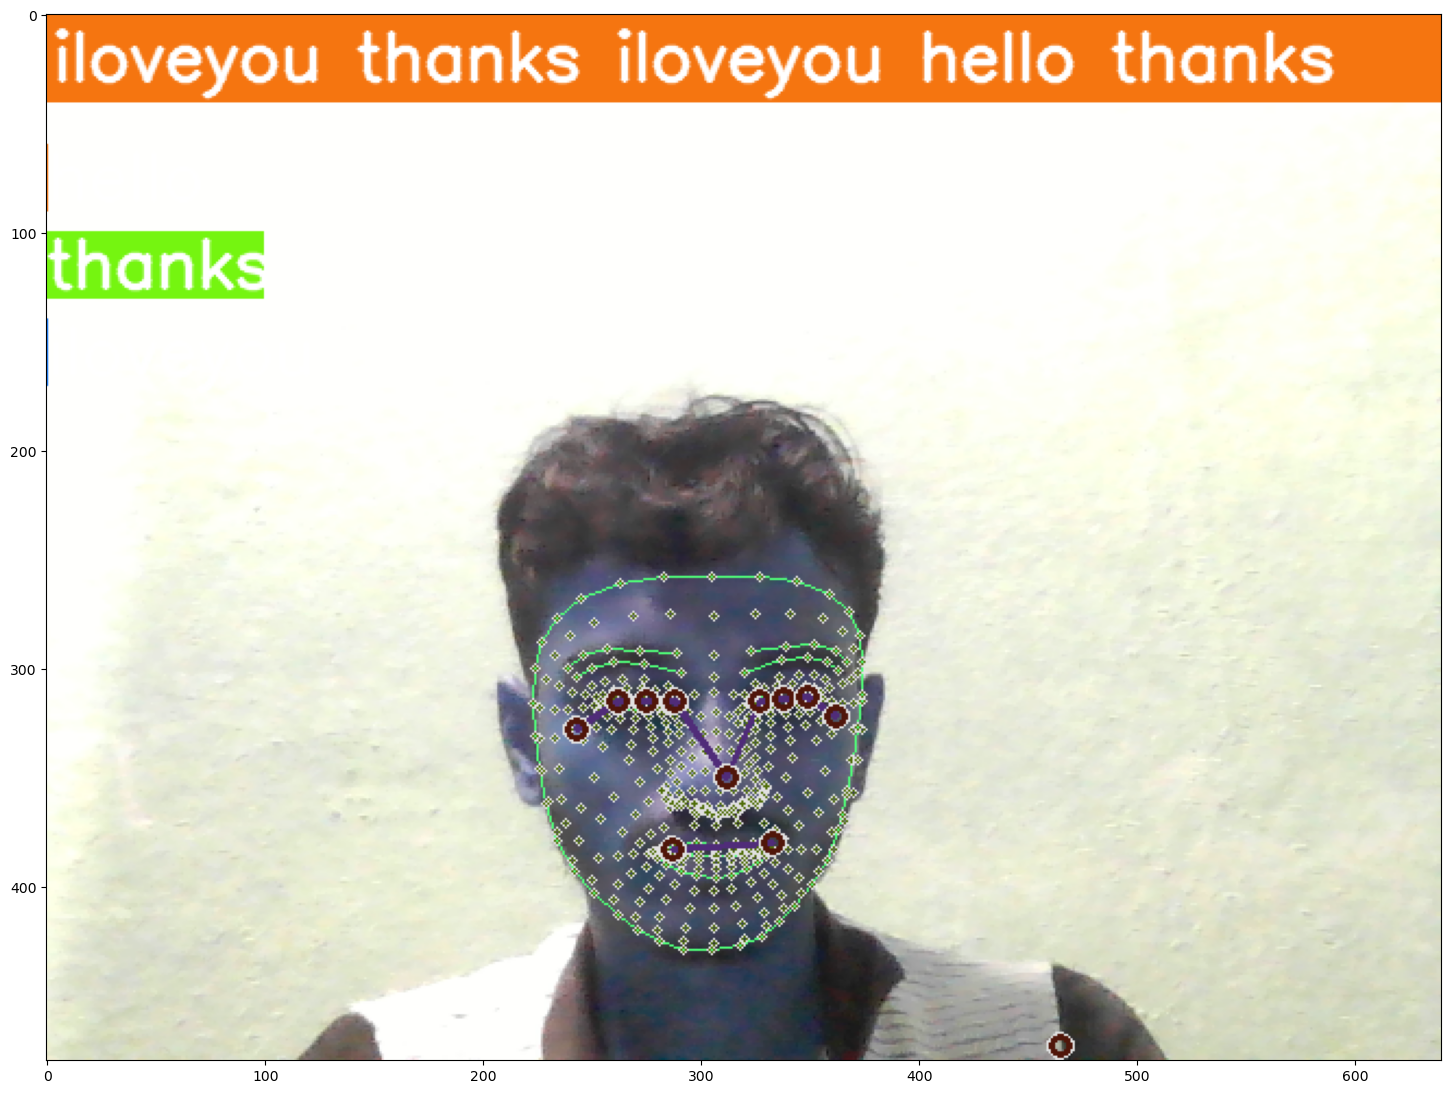

In [45]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))